# How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

## Imports & Settings

In [1]:
%matplotlib inline

import warnings
from datetime import datetime
import os
from pathlib import Path
import quandl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets
from pyfinance.ols import PandasRollingOLS
from sklearn.feature_selection import mutual_info_classif

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
idx = pd.IndexSlice

## Get Data

The `assets.h5` store can be generated using the `get_data.py` script in the `data` folder in the root directory of this repo.

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

In [3]:
with pd.HDFStore('../../data/assets.h5') as store:
    prices = store['quandl/wiki/prices'].loc[idx['2000':'2018', :], 'adj_close'].unstack('ticker')
    stocks = store['us_equities/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']]
    stocks = stocks[~stocks.index.duplicated()]

### Keep data with stock info

In [39]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6834 entries, PIH to ZYME
Data columns (total 3 columns):
marketcap    5766 non-null float64
ipoyear      3038 non-null float64
sector       5288 non-null object
dtypes: float64(2), object(1)
memory usage: 213.6+ KB


In [5]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


## Create monthly return series

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [6]:
monthly_prices = prices.resample('M').last()

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [7]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 521806 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 6 columns):
return_1m     521806 non-null float64
return_2m     521806 non-null float64
return_3m     521806 non-null float64
return_6m     521806 non-null float64
return_9m     521806 non-null float64
return_12m    521806 non-null float64
dtypes: float64(6)
memory usage: 25.9+ MB


## Drop stocks with less than 10 yrs of returns

In [8]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 6 columns):
return_1m     465935 non-null float64
return_2m     465935 non-null float64
return_3m     465935 non-null float64
return_6m     465935 non-null float64
return_9m     465935 non-null float64
return_12m    465935 non-null float64
dtypes: float64(6)
memory usage: 23.1+ MB


In [9]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,465935.000000,465935.000000,465935.000000,465935.000000,465935.000000,465935.000000
mean,0.011694,0.008454,0.007306,0.006036,0.005542,0.005285
std,0.117872,0.084059,0.069195,0.050674,0.041919,0.036635
min,-0.343442,-0.269341,-0.229978,-0.175426,-0.145071,-0.125787
25%,-0.046679,-0.031096,-0.024413,-0.015632,-0.012035,-0.009962
50%,0.006369,0.007476,0.007810,0.008024,0.007924,0.007852
75%,0.065314,0.048890,0.041722,0.031742,0.027062,0.024439
max,0.449446,0.294075,0.230064,0.159207,0.128147,0.108809


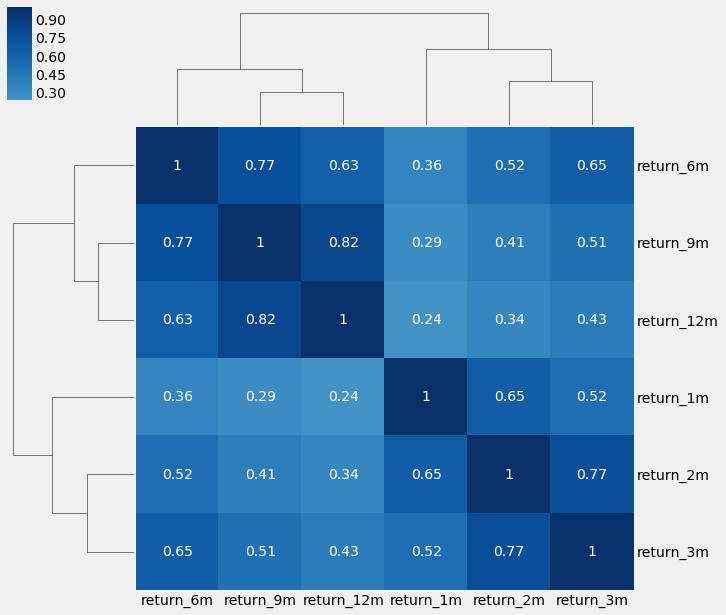

In [10]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

In [11]:
data.index.get_level_values('ticker').nunique()

2385

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in Chapter 8, Time Series Models.

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `PandasRollingOLS` rolling linear regression functionality in the `pyfinance` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [12]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 229 entries, 2000-01-31 to 2019-01-31
Freq: M
Data columns (total 5 columns):
Mkt-RF    229 non-null float64
SMB       229 non-null float64
HML       229 non-null float64
RMW       229 non-null float64
CMA       229 non-null float64
dtypes: float64(5)
memory usage: 10.7 KB


In [13]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 6 columns):
Mkt-RF       465935 non-null float64
SMB          465935 non-null float64
HML          465935 non-null float64
RMW          465935 non-null float64
CMA          465935 non-null float64
return_1m    465935 non-null float64
dtypes: float64(6)
memory usage: 23.1+ MB


In [14]:
T = 24
betas = (factor_data
         .groupby(level='ticker', group_keys=False)
         .apply(lambda x: PandasRollingOLS(window=min(T, x.shape[0]-1), y=x.return_1m, x=x.drop('return_1m', axis=1)).beta))

In [15]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,411080.000000,411080.000000,411080.000000,411080.000000,411080.000000,411080.000000
mean,0.973276,0.636905,0.115680,-0.109714,0.014188,1.630334
std,0.950979,1.306278,1.640647,2.087014,2.294009,3.761050
min,-9.299133,-10.348230,-15.841467,-26.847231,-20.607433,-38.504089
25%,0.426790,-0.119365,-0.718606,-1.089969,-1.132332,-0.248650
50%,0.917979,0.543192,0.076118,0.000000,0.022736,1.562578
75%,1.461661,1.333929,0.931474,0.979235,1.173293,3.536208
max,10.549881,10.710497,15.024651,18.378405,18.969999,36.688828


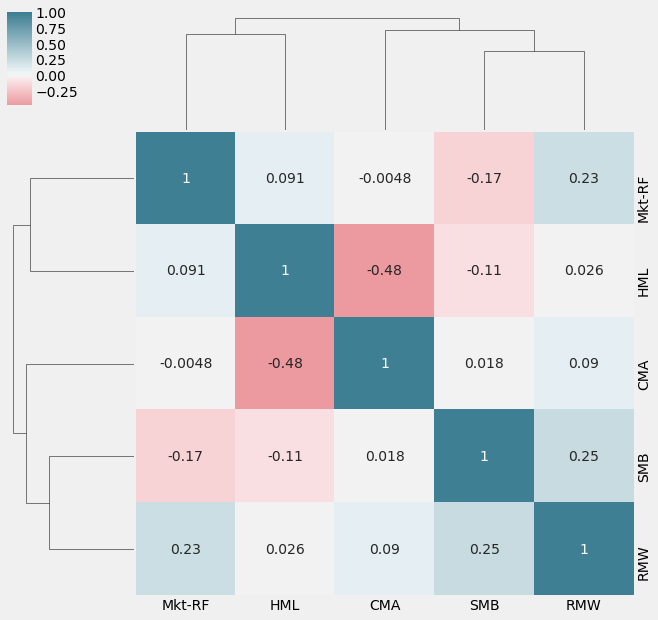

In [16]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [17]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 11 columns):
return_1m     465935 non-null float64
return_2m     465935 non-null float64
return_3m     465935 non-null float64
return_6m     465935 non-null float64
return_9m     465935 non-null float64
return_12m    465935 non-null float64
Mkt-RF        408695 non-null float64
SMB           408695 non-null float64
HML           408695 non-null float64
RMW           408695 non-null float64
CMA           408695 non-null float64
dtypes: float64(11)
memory usage: 60.9+ MB


### Impute mean for missing factor betas

In [18]:
data.loc[:, factors] = data.groupby('ticker')[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 11 columns):
return_1m     465935 non-null float64
return_2m     465935 non-null float64
return_3m     465935 non-null float64
return_6m     465935 non-null float64
return_9m     465935 non-null float64
return_12m    465935 non-null float64
Mkt-RF        465935 non-null float64
SMB           465935 non-null float64
HML           465935 non-null float64
RMW           465935 non-null float64
CMA           465935 non-null float64
dtypes: float64(11)
memory usage: 60.9+ MB


## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [19]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

## Date Indicators

In [20]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Lagged returns

To use lagged values as input variables or features associated with the current observations, we use the .shift() method to move historical returns up to the current period:

In [21]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 25 columns):
return_1m        465935 non-null float64
return_2m        465935 non-null float64
return_3m        465935 non-null float64
return_6m        465935 non-null float64
return_9m        465935 non-null float64
return_12m       465935 non-null float64
Mkt-RF           465935 non-null float64
SMB              465935 non-null float64
HML              465935 non-null float64
RMW              465935 non-null float64
CMA              465935 non-null float64
momentum_2       465935 non-null float64
momentum_3       465935 non-null float64
momentum_6       465935 non-null float64
momentum_9       465935 non-null float64
momentum_12      465935 non-null float64
momentum_3_12    465935 non-null float64
year             465935 non-null int64
month            465935 non-null int64
return_1m_t-1    463550 non-null float64
return_1m_t-2    461165 non-n

## Target: Holding Period Returns

Similarly, to compute returns for various holding periods, we use the normalized period returns computed previously and shift them back to align them with the current financial features

In [22]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [23]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
ticker date                                                                
A      2001-04-30  -0.140220  -0.087246  -0.098192   0.269444   0.040966   
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.140220   0.044721   
       2001-06-30  -0.119692  -0.097014  -0.155847  -0.031008  -0.087246   
       2001-07-31  -0.073750  -0.173364  -0.080114  -0.119692  -0.076414   
       2001-08-31  -0.262264  -0.083279   0.009593  -0.073750  -0.097014   
       2001-09-30   0.139130   0.181052   0.134010  -0.262264  -0.173364   
       2001-10-31   0.224517   0.131458   0.108697   0.139130  -0.083279   
       2001-11-30   0.045471   0.054962   0.045340   0.224517   0.181052   
       2001-12-31   0.064539   0.045275   0.070347   0.045471   0.131458   
       2002-01-31   0.026359   0.073264  -0.003306   0.064539   0.054962   

                   return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
ticker date                                                                
A      2001-04-30  -0.105747      -0.146389      -0.340055      -0.003653  
       2001-05-31  -0.023317       0.269444      -0.146389      -0.340055  
       2001-06-30   0.018842      -0.140220       0.269444      -0.146389  
       2001-07-31  -0.098192      -0.031008      -0.140220       0.269444  
       2001-08-31  -0.075527      -0.119692      -0.031008      -0.140220  
       2001-09-30  -0.155847      -0.073750      -0.119692      -0.031008  
       2001-10-31  -0.080114      -0.262264      -0.073750      -0.119692  
       2001-11-30   0.009593       0.139130      -0.262264      -0.073750  
       2001-12-31   0.134010       0.224517       0.139130      -0.262264  
       2002-01-31   0.108697       0.045471       0.224517       0.139130

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 30 columns):
return_1m        465935 non-null float64
return_2m        465935 non-null float64
return_3m        465935 non-null float64
return_6m        465935 non-null float64
return_9m        465935 non-null float64
return_12m       465935 non-null float64
Mkt-RF           465935 non-null float64
SMB              465935 non-null float64
HML              465935 non-null float64
RMW              465935 non-null float64
CMA              465935 non-null float64
momentum_2       465935 non-null float64
momentum_3       465935 non-null float64
momentum_6       465935 non-null float64
momentum_9       465935 non-null float64
momentum_12      465935 non-null float64
momentum_3_12    465935 non-null float64
year             465935 non-null int64
month            465935 non-null int64
return_1m_t-1    463550 non-null float64
return_1m_t-2    461165 non-n

## Create age proxy

In [25]:
data = (data
        .join(pd.qcut(stocks.ipoyear, q=5, labels=list(range(1, 6)))
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age')))
data.age = data.age.fillna(-1)

## Create dynamic size proxy

In [44]:
with pd.HDFStore('../../data/assets.h5') as store:
    stocks = store['us_equities/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']]
    stocks = stocks[~stocks.index.duplicated()]

In [45]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6834 entries, PIH to ZYME
Data columns (total 3 columns):
marketcap    5766 non-null float64
ipoyear      3038 non-null float64
sector       5288 non-null object
dtypes: float64(2), object(1)
memory usage: 213.6+ KB


In [46]:
stocks.head()

,marketcap,ipoyear,sector
ticker,,,
PIH,43090000.0,2014.0,Finance
PIHPP,NaN,NaN,Finance
TURN,70330000.0,NaN,Finance
FLWS,833390000.0,1999.0,Consumer Services
FCCY,178140000.0,NaN,Finance


### String preprocessing

In [41]:
stocks.marketcap = stocks.marketcap.astype(str).str.replace('$', '')
stocks['mcap'] = stocks.marketcap.str[-1]
stocks.marketcap =  pd.to_numeric(stocks.marketcap.str[:-1], errors='ignore')

In [42]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6834 entries, PIH to ZYME
Data columns (total 4 columns):
marketcap    6834 non-null object
ipoyear      3038 non-null float64
sector       5288 non-null object
mcap         6834 non-null object
dtypes: float64(1), object(3)
memory usage: 267.0+ KB


In [43]:
stocks.head()

,marketcap,ipoyear,sector,mcap
ticker,,,,
PIH,43090000.,2014.0,Finance,0
PIHPP,na,NaN,Finance,n
TURN,70330000.,NaN,Finance,0
FLWS,833390000.,1999.0,Consumer Services,0
FCCY,178140000.,NaN,Finance,0


In [36]:

stocks = stocks[stocks.mcap.isin(['B', 'M'])]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 4 columns):
marketcap    0 non-null object
ipoyear      0 non-null float64
sector       0 non-null object
mcap         0 non-null object
dtypes: float64(1), object(3)
memory usage: 0.0+ bytes


In [ ]:
stocks.marketcap = stocks.apply(lambda x: x.marketcap * 1000 if x.mcap == 'B' else x.marketcap, axis=1)
stocks.marketcap.describe()

In [47]:
size_factor = (monthly_prices
               .loc[data.index.get_level_values('date').unique(),
                    data.index.get_level_values('ticker').unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               .cumprod())
size_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207 entries, 2018-03-31 to 2001-01-31
Freq: -1M
Columns: 2385 entries, A to UFS
dtypes: float64(2385)
memory usage: 3.8 MB


In [48]:
msize = (size_factor
         .mul(stocks
              .loc[size_factor.columns, 'marketcap'])).dropna(axis=1, how='all')

In [49]:
data['msize'] = (msize
                 .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                 .stack()
                 .swaplevel())
data.msize = data.msize.fillna(-1)

## Combine data

In [50]:
data = data.join(stocks[['sector']])
data.sector = data.sector.fillna('Unknown')

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 33 columns):
return_1m        465935 non-null float64
return_2m        465935 non-null float64
return_3m        465935 non-null float64
return_6m        465935 non-null float64
return_9m        465935 non-null float64
return_12m       465935 non-null float64
Mkt-RF           465935 non-null float64
SMB              465935 non-null float64
HML              465935 non-null float64
RMW              465935 non-null float64
CMA              465935 non-null float64
momentum_2       465935 non-null float64
momentum_3       465935 non-null float64
momentum_6       465935 non-null float64
momentum_9       465935 non-null float64
momentum_12      465935 non-null float64
momentum_3_12    465935 non-null float64
year             465935 non-null int64
month            465935 non-null int64
return_1m_t-1    463550 non-null float64
return_1m_t-2    461165 non-n

## Store data

We will use the data again in [Chapter 6](../../06_machine_learning_process/02_mutual_information/mutual_information.ipynb).

In [53]:
with pd.HDFStore('data.h5') as store:
    store.put('engineered_features', data.sort_index().loc[idx[:, :datetime(2018, 3, 1)], :])

## Create Dummy variables

In [54]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 89 columns):
return_1m                465935 non-null float64
return_2m                465935 non-null float64
return_3m                465935 non-null float64
return_6m                465935 non-null float64
return_9m                465935 non-null float64
return_12m               465935 non-null float64
Mkt-RF                   465935 non-null float64
SMB                      465935 non-null float64
HML                      465935 non-null float64
RMW                      465935 non-null float64
CMA                      465935 non-null float64
momentum_2               465935 non-null float64
momentum_3               465935 non-null float64
momentum_6               465935 non-null float64
momentum_9               465935 non-null float64
momentum_12              465935 non-null float64
momentum_3_12            465935 non-null float64
return_1m_t-

### Mutual Information

#### Original Data

In [55]:
target_labels = [f'target_{i}m' for i in [1,2,3,6,12]]
targets = data.dropna().loc[:, target_labels]

features = data.dropna().drop(target_labels, axis=1)
features.sector = pd.factorize(features.sector)[0]

cat_cols = ['year', 'month', 'msize', 'age', 'sector']
discrete_features = [features.columns.get_loc(c) for c in cat_cols]

In [56]:
mutual_info = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=features, 
                             y=(targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )
    mutual_info[label] = pd.Series(mi, index=features.columns)

In [57]:
mutual_info.sum()

target_1m     0.194954
target_2m     0.224430
target_3m     0.255852
target_6m     0.318503
target_12m    0.387242
dtype: float64

#### Normalized MI Heatmap

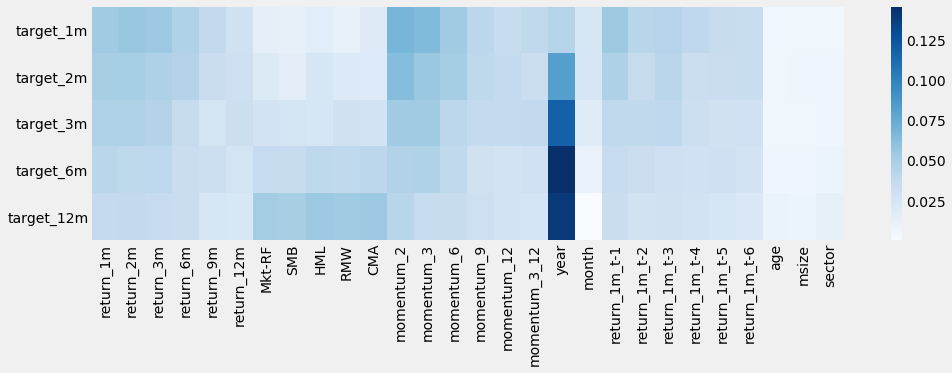

In [58]:
fig, ax= plt.subplots(figsize=(15, 4))
sns.heatmap(mutual_info.div(mutual_info.sum()).T, ax=ax, cmap='Blues');

#### Dummy Data

In [59]:
target_labels = [f'target_{i}m' for i in [1, 2, 3, 6, 12]]
dummy_targets = dummy_data.dropna().loc[:, target_labels]

dummy_features = dummy_data.dropna().drop(target_labels, axis=1)
cat_cols = [c for c in dummy_features.columns if c not in features.columns]
discrete_features = [dummy_features.columns.get_loc(c) for c in cat_cols]

In [60]:
mutual_info_dummies = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=dummy_features, 
                             y=(dummy_targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )    
    mutual_info_dummies[label] = pd.Series(mi, index=dummy_features.columns)

In [61]:
mutual_info_dummies.sum()

target_1m     0.197071
target_2m     0.227540
target_3m     0.259866
target_6m     0.324267
target_12m    0.394604
dtype: float64

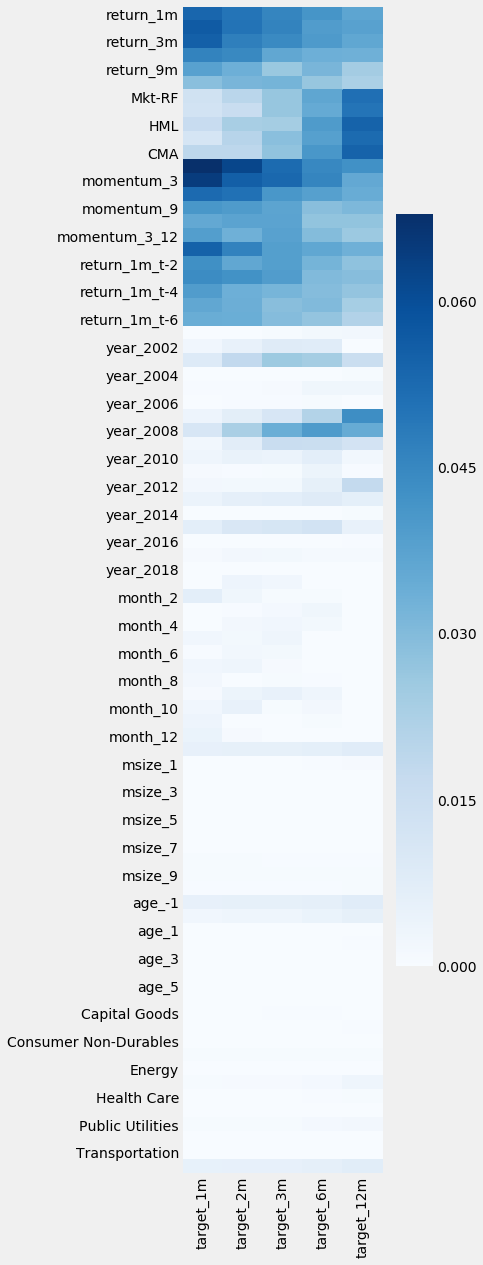

In [62]:
fig, ax= plt.subplots(figsize=(4, 20))
sns.heatmap(mutual_info_dummies.div(mutual_info_dummies.sum()), ax=ax, cmap='Blues');